In [26]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from math import gcd
import pandas as pd
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

def initialize_qubits(given_circuit, n, m):
    given_circuit.h(range(n))
    given_circuit.x(n + m - 1)

def c_amod15(a, x):
    if a not in [2, 7, 8, 11, 13]:
        raise ValueError("'a' must be 2, 7, 8, 11, or 13")
    U = QuantumCircuit(4)
    for iteration in range(x):
        if a in [2, 13]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [7, 8]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a == 11:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, x)
    c_U = U.control()
    return c_U

def modular_exponentiation(circuit, n, m, a):
    for x in range(n):
        exponent = 2**x
        circuit.append(c_amod15(a, int(exponent)), [x] + list(range(n, n + m)))

def inverse_qft(circuit, measurement_qubits):
    circuit.append(QFT(len(measurement_qubits), do_swaps=False).inverse(), measurement_qubits)

def shors_algorithm(n, m, a):
    qc = QuantumCircuit(n + m, n)
    initialize_qubits(qc, n, m)
    qc.barrier()
    modular_exponentiation(qc, n, m, a)
    qc.barrier()
    inverse_qft(qc, range(n))
    qc.measure(range(n), range(n))
    return qc

n = 4
m = 4
a = 7
final_circuit = shors_algorithm(n, m, a)

simulator = Aer.get_backend('qasm_simulator')
counts = execute(final_circuit, backend=simulator, shots=1000).result().get_counts(final_circuit)
for measured_value in counts:
    print(f"Measured value: {int(measured_value[::-1], 2)}")
for i in counts:
    measured_value = int(i[::-1], 2)

    if measured_value % 2 != 0:
        print("Measured value not even")
        continue  # measured value should be even as we are doing a^(r/2) mod N and r/2 should be int
    x = int((a ** (measured_value // 2)) % 15)
    if (x + 1) % 15 == 0:
        continue
    factors = gcd(x + 1, 15), gcd(x - 1, 15)  # we saw earlier that a^(r/2)+1 or a^(r/2)-1 should be a factor of 15
    print(f"Factors: {factors}")


13
4
8
15
11
0
10
7
9
12
6
5
14
Measured value not even
(5, 3)
(1, 15)
Measured value not even
Measured value not even
(1, 15)
(1, 3)
Measured value not even
Measured value not even
(5, 3)
(1, 3)
Measured value not even
(1, 3)


000


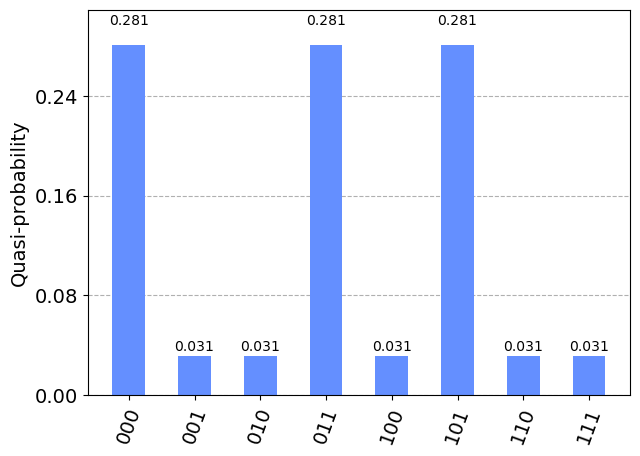

In [1]:
input_3sat_instance = '''
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

import os
import tempfile
from qiskit.exceptions import MissingOptionalLibraryError
from qiskit.circuit.library.phase_oracle import PhaseOracle


fp = tempfile.NamedTemporaryFile(mode='w+t', delete=False)
fp.write(input_3sat_instance)
file_name = fp.name
fp.close()
oracle = None
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except ImportError as ex:
    print(ex)
finally:
    os.remove(file_name)
    
from qiskit.algorithms import AmplificationProblem

problem = None
if oracle is not None:
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)

from qiskit.algorithms import Grover
from qiskit.primitives import Sampler

grover = Grover(sampler=Sampler())
result = None
if problem is not None:
    result = grover.amplify(problem)
    print(result.assignment)
    
from qiskit.tools.visualization import plot_histogram

if result is not None:
    display(plot_histogram(result.circuit_results[0]))